In [1]:
#uses this type of format:  [city]_xyz.[parquet or csv]
#data has to be checked for NANs and ohter inconsistencies before

In [2]:
import pandas as pd
import os
import json

# ============================================================
# CONFIGURATION - CHECK THE PATHS HERE
# ============================================================
INPUT_DIR = "../data/0_initial"
OUTPUT_DIR = "../data/3_outputs"

# Ensure that the destination folder exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

def process_weather_data():
    # Search for files
    if not os.path.exists(INPUT_DIR):
        print(f"❌ error: source directory {INPUT_DIR} not found!")
        return

    files = [f for f in os.listdir(INPUT_DIR) if f.lower().endswith(('.csv', '.parquet'))]
    print(f"Process {len(files)} files from {INPUT_DIR}...")

    for file in files:
        file_path = os.path.join(INPUT_DIR, file)
        
        # City name: Everything before the first '_'
        city_id = file.split('_')[0].lower()
        
        try:
            # Load data
            if file.lower().endswith('.csv'):
                df = pd.read_csv(file_path)
            else:
                df = pd.read_parquet(file_path)

            # Timestamp check
            if 'timestamp' not in df.columns:
                time_col = [c for c in df.columns if 'time' in c.lower()]
                if time_col:
                    df.rename(columns={time_col[0]: 'timestamp'}, inplace=True)
                else:
                    print(f"Skip {file}: No time column found")
                    continue

            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.sort_values('timestamp').reset_index(drop=True)

            # Extract metadata
            start_dt = df['timestamp'].min().strftime('%Y-%m-%d %H:%M:%S')
            end_dt = df['timestamp'].max().strftime('%Y-%m-%d %H:%M:%S')
            start_yr = df['timestamp'].min().year
            end_yr = df['timestamp'].max().year
            
            # List and count variables
            var_names = [c for c in df.columns if c != 'timestamp']
            var_count = len(var_names)

            # Build file names
            # Format: city_year-year_varsX_v1
            filename_base = f"{city_id}_{start_yr}-{end_yr}_vars{var_count}_v1"
            
            # Output paths
            final_parquet_path = os.path.join(OUTPUT_DIR, f"{filename_base}.parquet")
            final_json_path = os.path.join(OUTPUT_DIR, f"{filename_base}.json")

            # Save
            df.to_parquet(final_parquet_path, index=False)
            
            metadata = {
                "city": city_id,
                "time_frame": {
                    "start_exact": start_dt,
                    "end_exact": end_dt,
                    "rows": len(df)
                },
                "variables": {
                    "count": var_count,
                    "list": var_names  # All names are listed here
                }
            }

            with open(final_json_path, 'w') as f:
                json.dump(metadata, f, indent=4)

            print(f"✅ Created: {filename_base} (Variables: {var_count})")

        except Exception as e:
            print(f"❌ Error in {file}: {str(e)}")

if __name__ == "__main__":
    process_weather_data()

Process 5 files from ../data/0_initial...
✅ Created: marseillemarignane_1990-2025_vars14_v1 (Variables: 14)
✅ Created: paris_1990-2025_vars14_v1 (Variables: 14)
✅ Created: bordeaux_1990-2025_vars14_v1 (Variables: 14)
✅ Created: lyon_1990-2025_vars14_v1 (Variables: 14)
✅ Created: marseille_1990-2025_vars14_v1 (Variables: 14)



STATISTICAL SUMMARY (Refined Colors)


,City,temperature_2m (Mean),temperature_2m (Std),temperature_2m (Max),relative_humidity_2m (Mean),relative_humidity_2m (Std),relative_humidity_2m (Max),pressure_msl (Mean),pressure_msl (Std),pressure_msl (Max),shortwave_radiation (Mean),shortwave_radiation (Std),shortwave_radiation (Max),soil_moisture_0_to_7cm (Mean),soil_moisture_0_to_7cm (Std),soil_moisture_0_to_7cm (Max),wind_speed_10m (Mean),wind_speed_10m (Std),wind_speed_10m (Max),t_850hPa (Mean),t_850hPa (Std),t_850hPa (Max),t_500hPa (Mean),t_500hPa (Std),t_500hPa (Max),u_850hPa (Mean),u_850hPa (Std),u_850hPa (Max),u_500hPa (Mean),u_500hPa (Std),u_500hPa (Max),v_850hPa (Mean),v_850hPa (Std),v_850hPa (Max),v_500hPa (Mean),v_500hPa (Std),v_500hPa (Max),wind_dir_sin (Mean),wind_dir_sin (Std),wind_dir_sin (Max),wind_dir_cos (Mean),wind_dir_cos (Std),wind_dir_cos (Max)
0,lyon,12.38,7.98,40.25,74.74,17.04,100.00,1017.59,7.83,1046.00,153.99,229.42,950.00,0.33,0.08,0.43,10.04,6.18,55.48,279.24,6.65,301.01,254.82,5.89,269.01,1.91,4.98,34.72,7.42,10.36,62.00,-0.28,8.28,39.79,-1.94,11.24,45.68,-0.21,0.52,1.00,0.06,0.83,1.00
1,marseille,15.57,6.65,36.85,71.48,15.49,100.00,1015.93,6.97,1042.30,187.89,264.28,981.00,0.26,0.09,0.44,13.80,8.89,63.95,281.60,6.24,301.08,255.77,5.86,270.32,2.10,5.73,35.21,7.97,10.09,53.60,-2.02,8.33,30.40,-2.34,10.59,44.73,-0.05,0.70,1.00,0.22,0.67,1.00
2,marseillemarignane,15.24,7.80,39.04,68.80,19.20,100.00,1015.95,6.98,1042.30,187.82,264.18,981.00,0.25,0.09,0.44,13.61,8.69,59.73,281.42,6.21,300.97,255.69,5.86,270.23,1.62,5.32,32.73,7.89,10.11,54.17,-1.92,8.47,29.80,-2.33,10.64,45.81,-0.04,0.70,1.00,0.22,0.68,1.00
3,bordeaux,13.92,7.13,41.65,75.55,17.43,100.00,1017.71,8.06,1045.80,157.82,230.94,969.00,0.28,0.08,0.44,10.22,5.04,62.87,279.86,6.11,302.68,255.47,5.70,269.53,3.91,6.98,50.61,8.62,10.94,67.91,-0.15,5.59,32.03,-1.59,11.14,41.66,-0.11,0.72,1.00,0.08,0.68,1.00
4,paris,11.80,7.09,40.70,76.84,15.81,100.00,1016.82,9.21,1047.50,135.19,207.84,921.00,0.31,0.08,0.44,12.76,6.46,59.04,277.73,5.87,299.01,253.96,5.84,268.65,4.07,7.90,39.61,8.81,11.74,71.57,0.53,6.45,35.44,-0.95,11.88,46.74,-0.16,0.67,1.00,-0.03,0.72,1.00


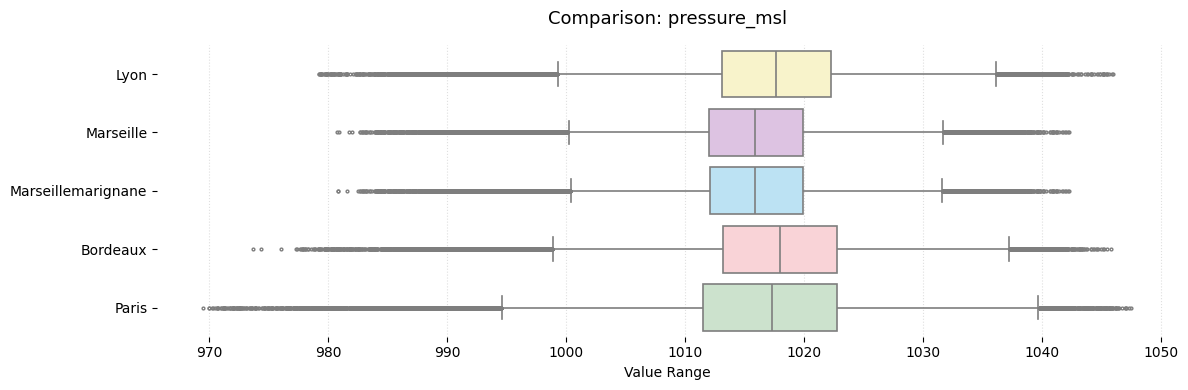

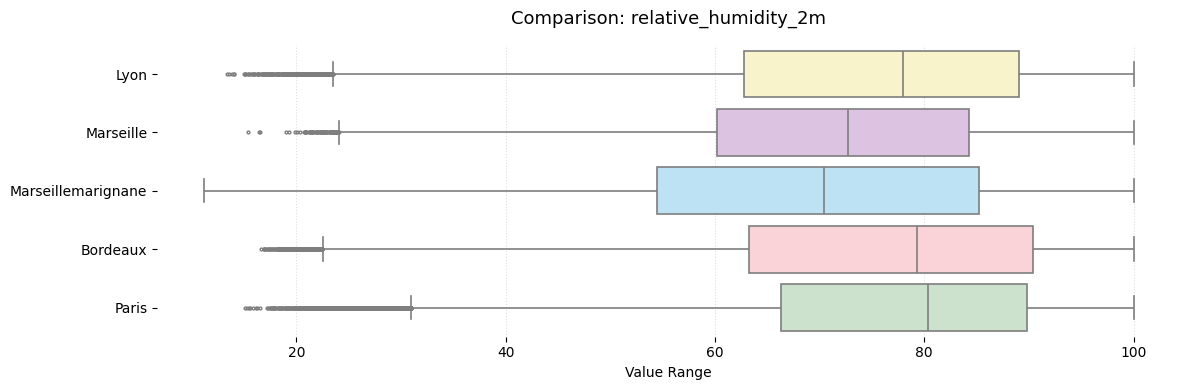

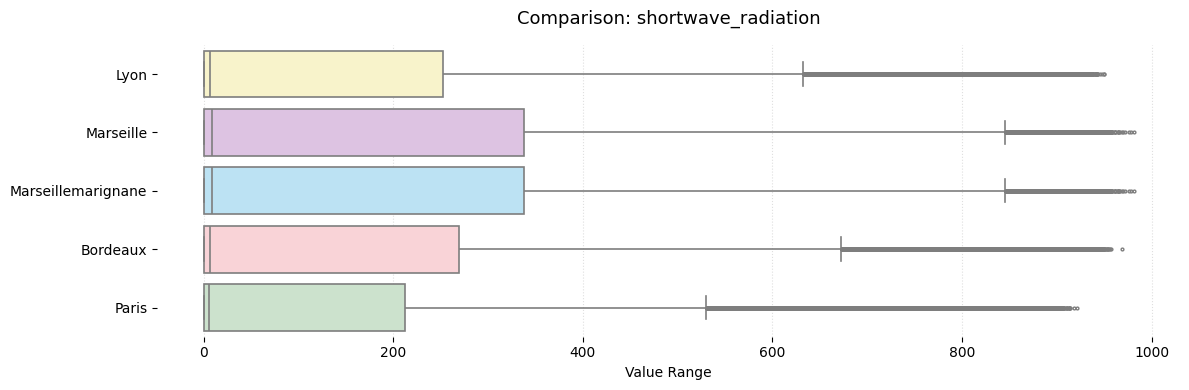

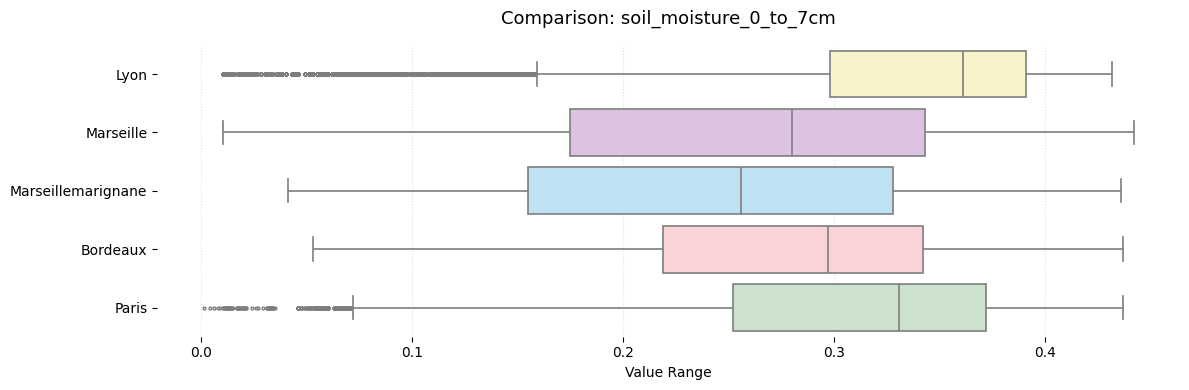

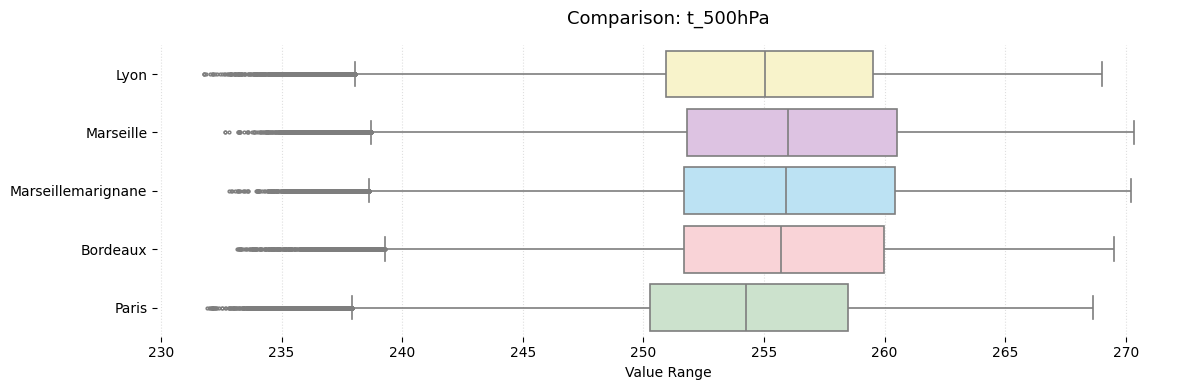

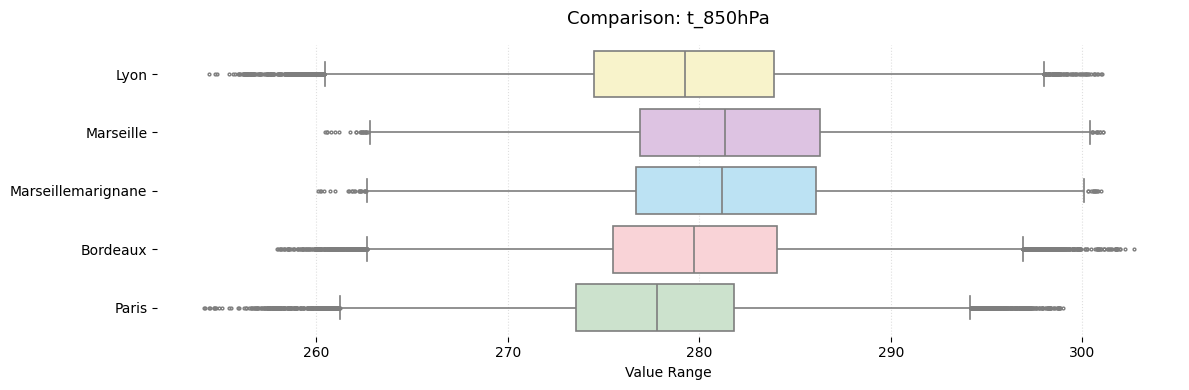

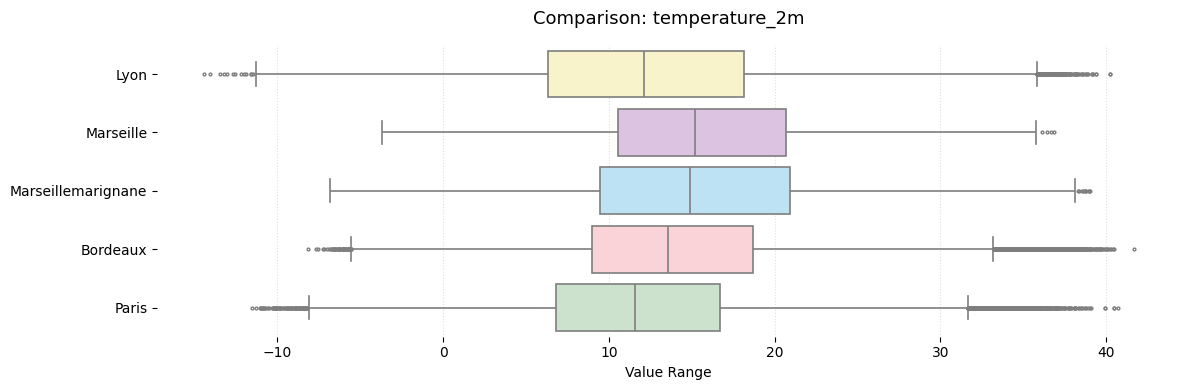

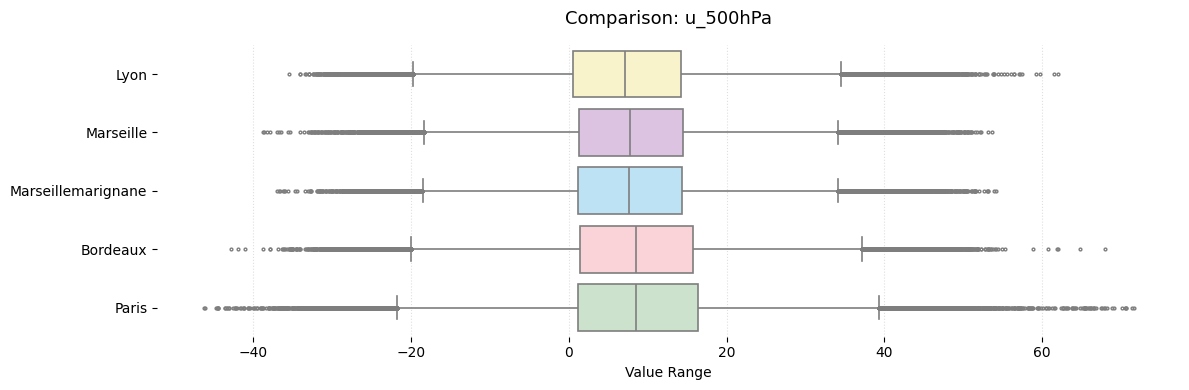

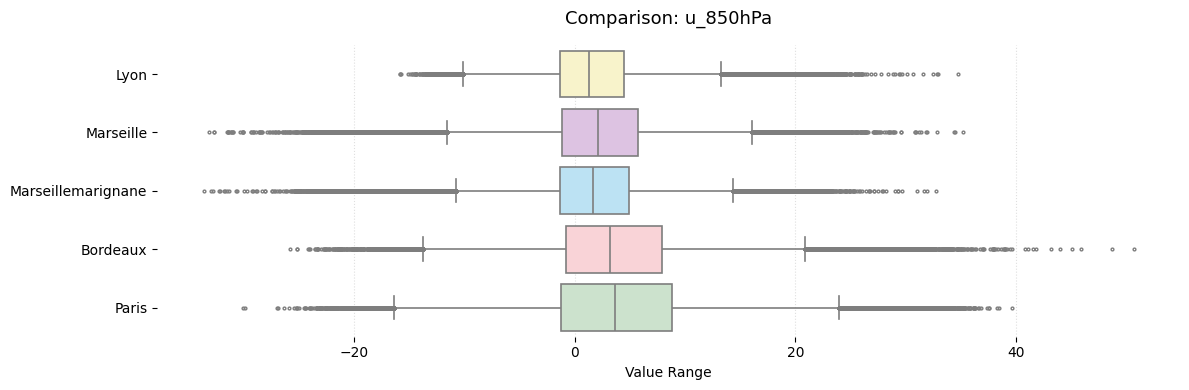

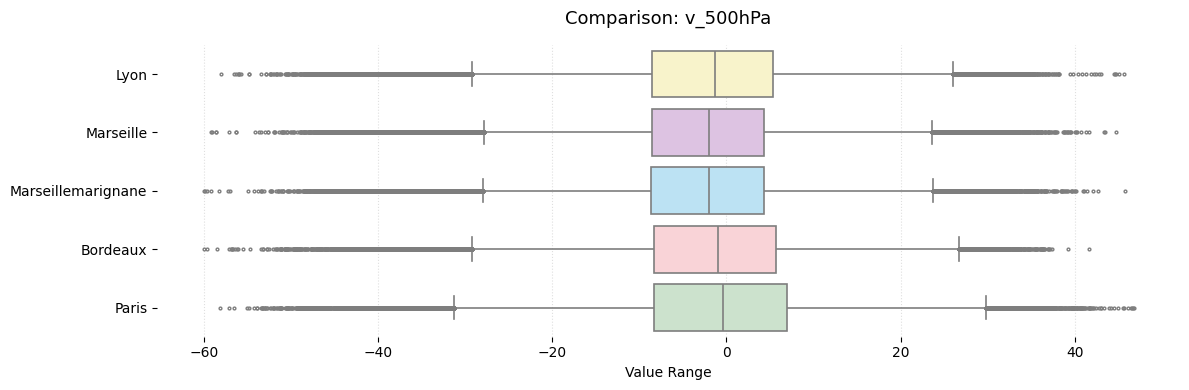

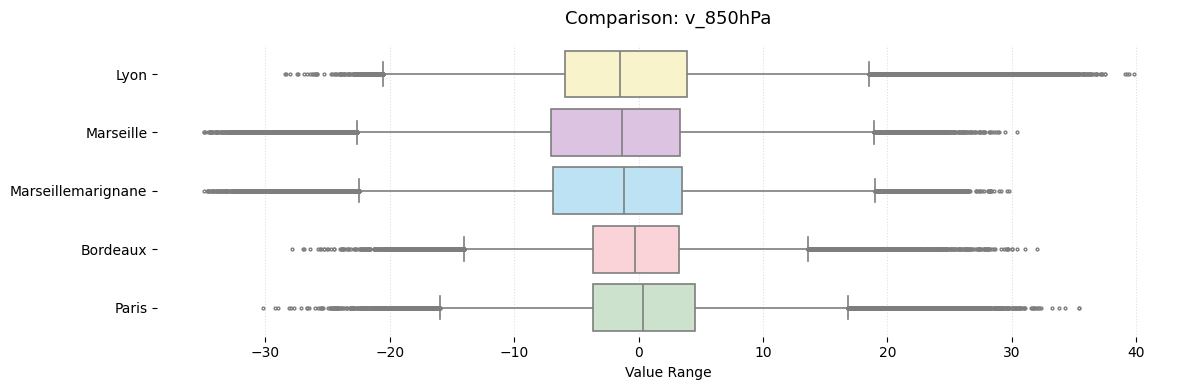

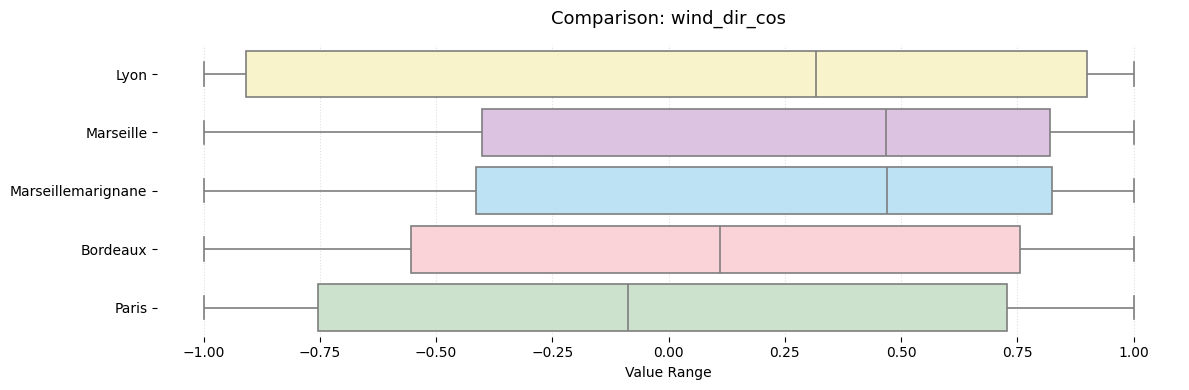

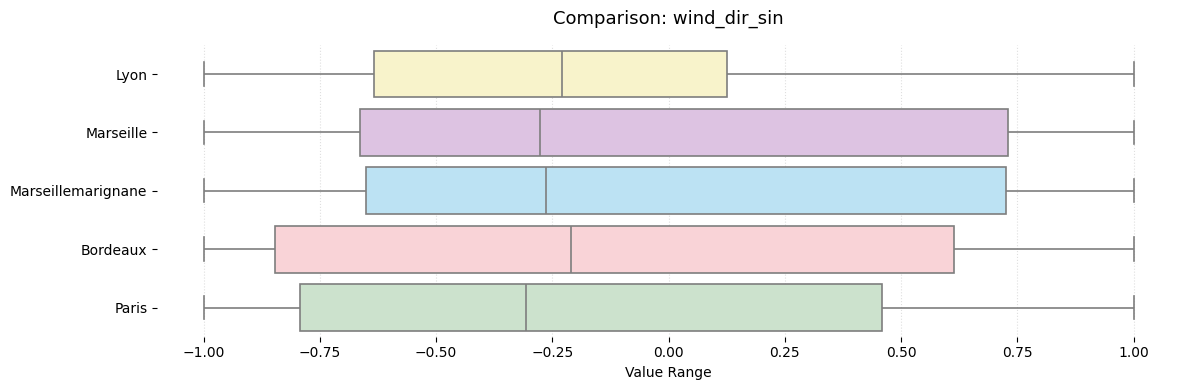

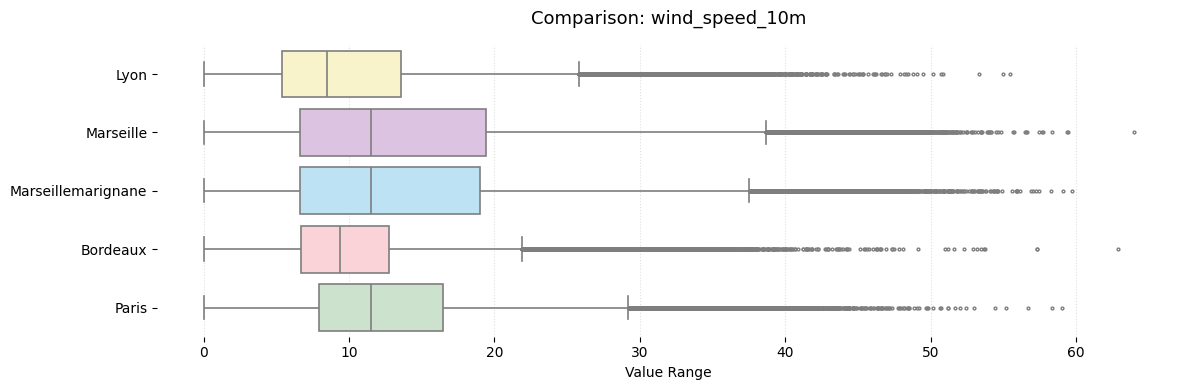

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json

# ============================================================
# CONFIGURATION & REFINED SOFT COLOR SCHEME
# ============================================================
SOURCE_DIR = "../data/3_outputs"

CITY_COLORS = {
    "lyon": "#FFF9C4",                
    "marseillemarignane": "#B3E5FC",
    "marseille": "#E1BEE7",      
    "paris": "#C8E6C9",
    "bordeaux": "#FFCDD2"
}

all_frames = {}
city_metadata = {}
unique_variables = set()

# Load data and log information
parquet_files = [f for f in os.listdir(SOURCE_DIR) if f.endswith('.parquet')]

for file in parquet_files:
    file_path = os.path.join(SOURCE_DIR, file)
    json_path = file_path.replace('.parquet', '.json')
    
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            meta = json.load(f)
        
        city_id = meta['city'].lower().replace("_", "")
        vars_list = meta['variables']['list']
        
        for v in vars_list:
            unique_variables.add(v)
            
        all_frames[city_id] = pd.read_parquet(file_path)
        city_metadata[city_id] = vars_list

# --- STATISTICAL SUMMARY ---
summary_list = []
for loc, df in all_frames.items():
    loc_stats = {"City": loc}
    for var in city_metadata[loc]:
        loc_stats[f"{var} (Mean)"] = df[var].mean()
        loc_stats[f"{var} (Std)"] = df[var].std()
        loc_stats[f"{var} (Max)"] = df[var].max()
    summary_list.append(loc_stats)

df_summary = pd.DataFrame(summary_list)

# --- BEAUTIFUL RENDERING ---
print("\n" + "="*80)
print("STATISTICAL SUMMARY (Refined Colors)")
print("="*80)

def color_city_rows(row):
    color = CITY_COLORS.get(row['City'].lower(), 'white')
    return [f'background-color: {color}; color: black; font-weight: bold' if i==0 else '' for i in range(len(row))]

styled_df = df_summary.style.format(precision=2) \
    .background_gradient(cmap='coolwarm', subset=df_summary.columns[1:], axis=0) \
    .apply(color_city_rows, axis=1) \
    .set_properties(**{'text-align': 'center', 'border': '1px solid #eee'})

display(styled_df)

# --- GRAPHICAL ANALYSIS (box plots) ---
for var in sorted(list(unique_variables)):
    valid_cities = {loc: df for loc, df in all_frames.items() if var in city_metadata[loc]}
    
    if valid_cities:
        plt.figure(figsize=(12, 4))
        
        # Palette matching the cities in this particular plot
        current_palette = [CITY_COLORS.get(loc.lower(), "#F5F5F5") for loc in valid_cities.keys()]
        
        data_to_plot = pd.concat([df[var].rename(loc.title()) for loc, df in valid_cities.items()], axis=1)
        
        # Plotting
        sns.boxplot(data=data_to_plot, orient="h", palette=current_palette, linewidth=1.2, fliersize=2)
        
        plt.title(f"Comparison: {var}", fontsize=13, fontweight='500', pad=15)
        plt.xlabel("Value Range")
        plt.grid(axis='x', linestyle=':', alpha=0.4)
        
        # Clean Look
        sns.despine(left=True, bottom=True)
        plt.tight_layout()
        plt.show()

🔍 Start normal distribution check for: pressure_msl


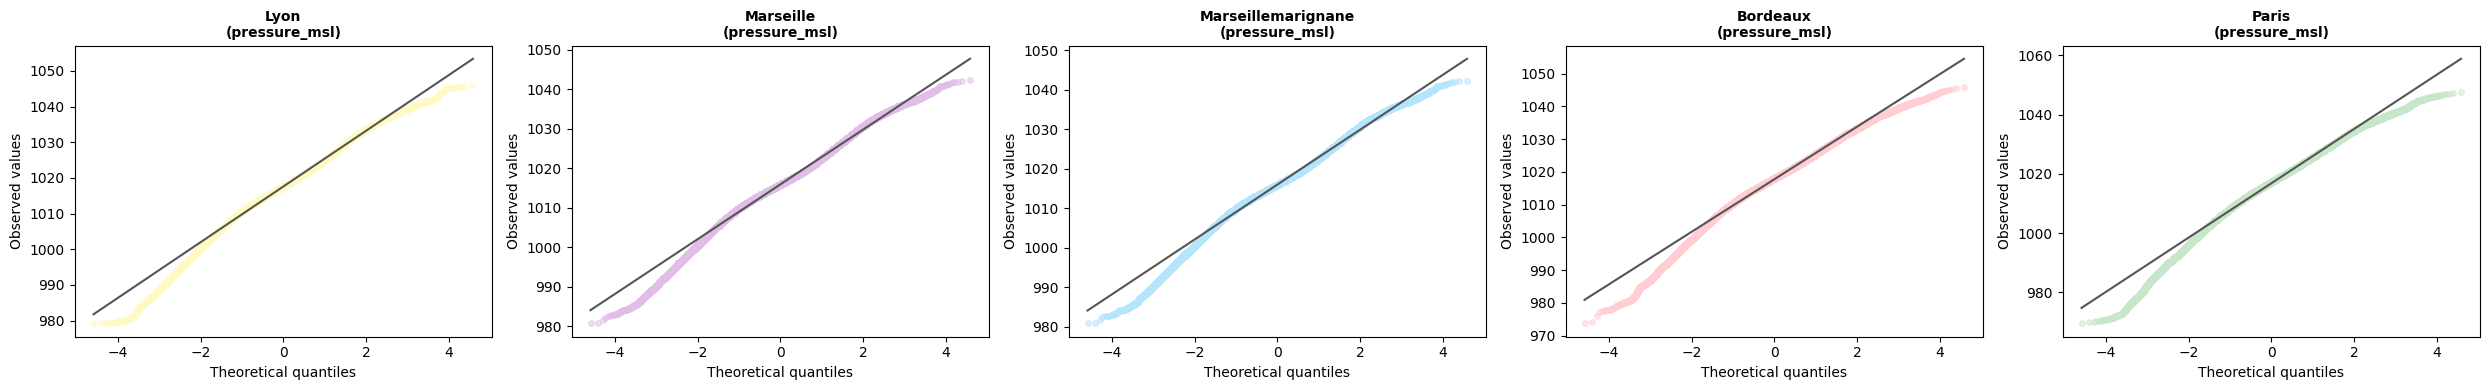

🔍 Start normal distribution check for: relative_humidity_2m


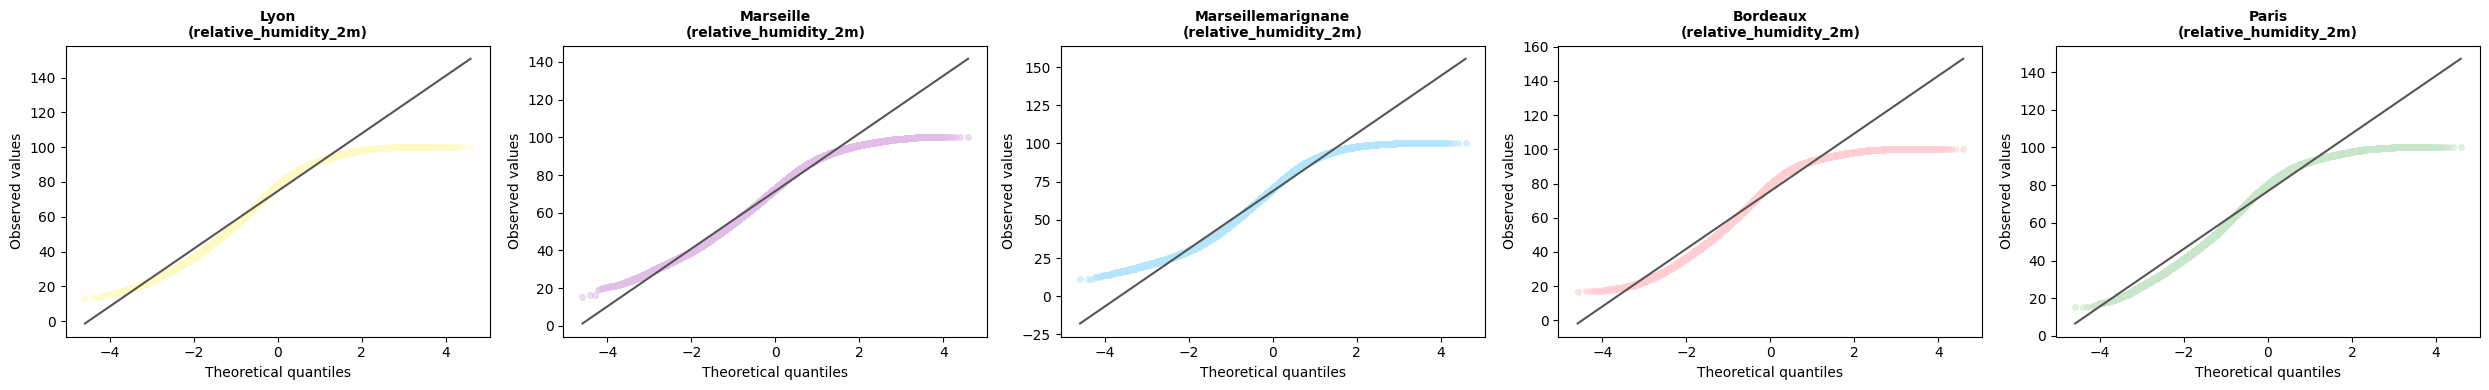

🔍 Start normal distribution check for: shortwave_radiation


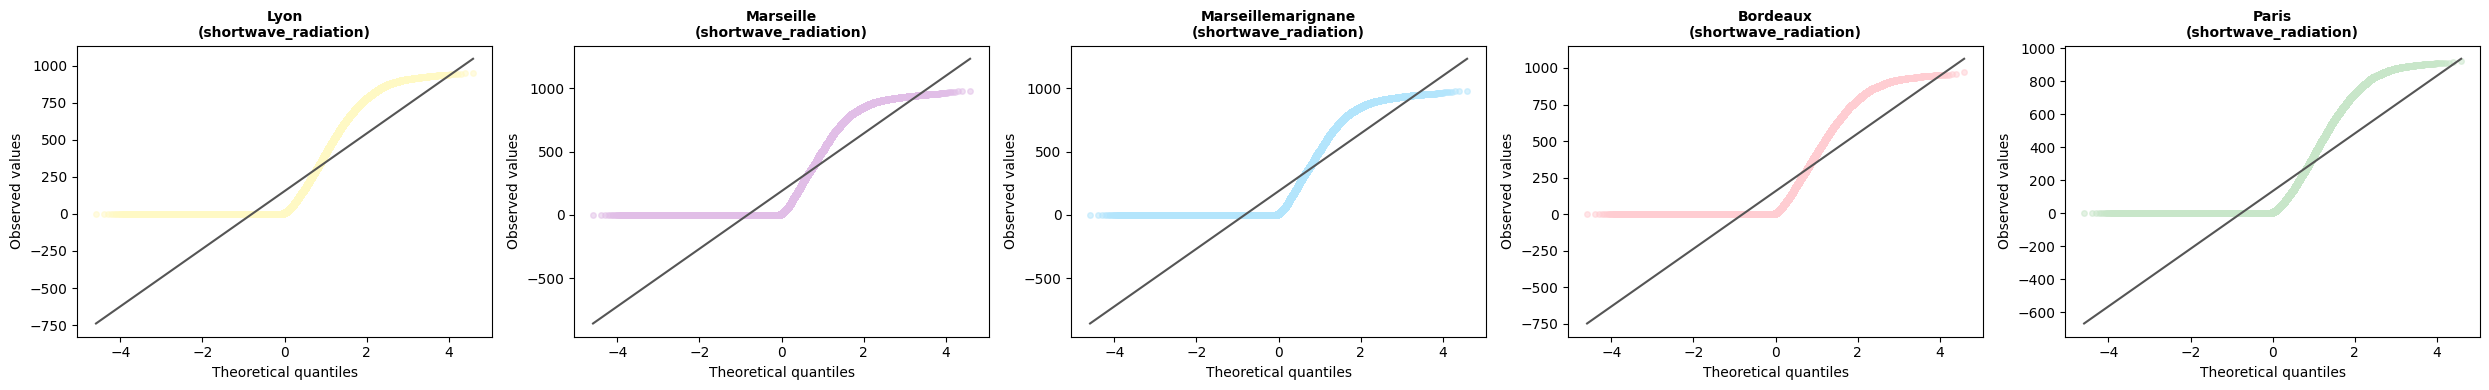

🔍 Start normal distribution check for: soil_moisture_0_to_7cm


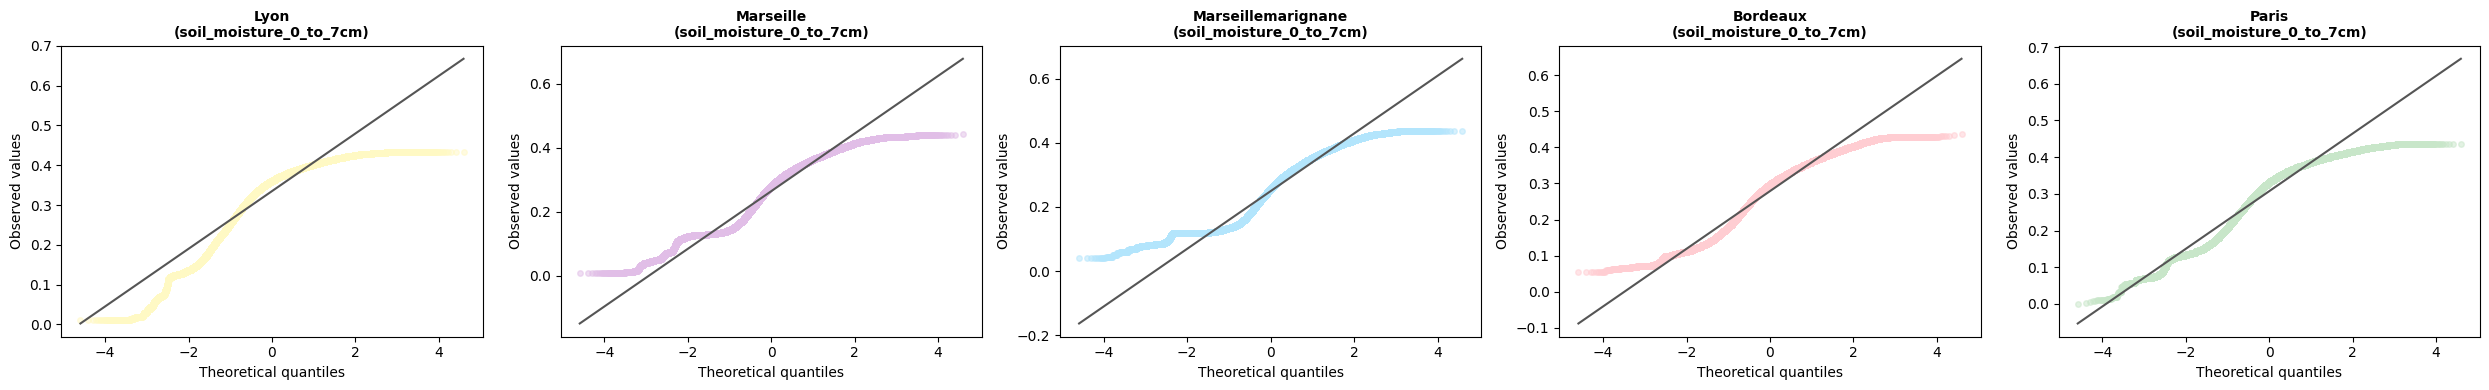

🔍 Start normal distribution check for: t_500hPa


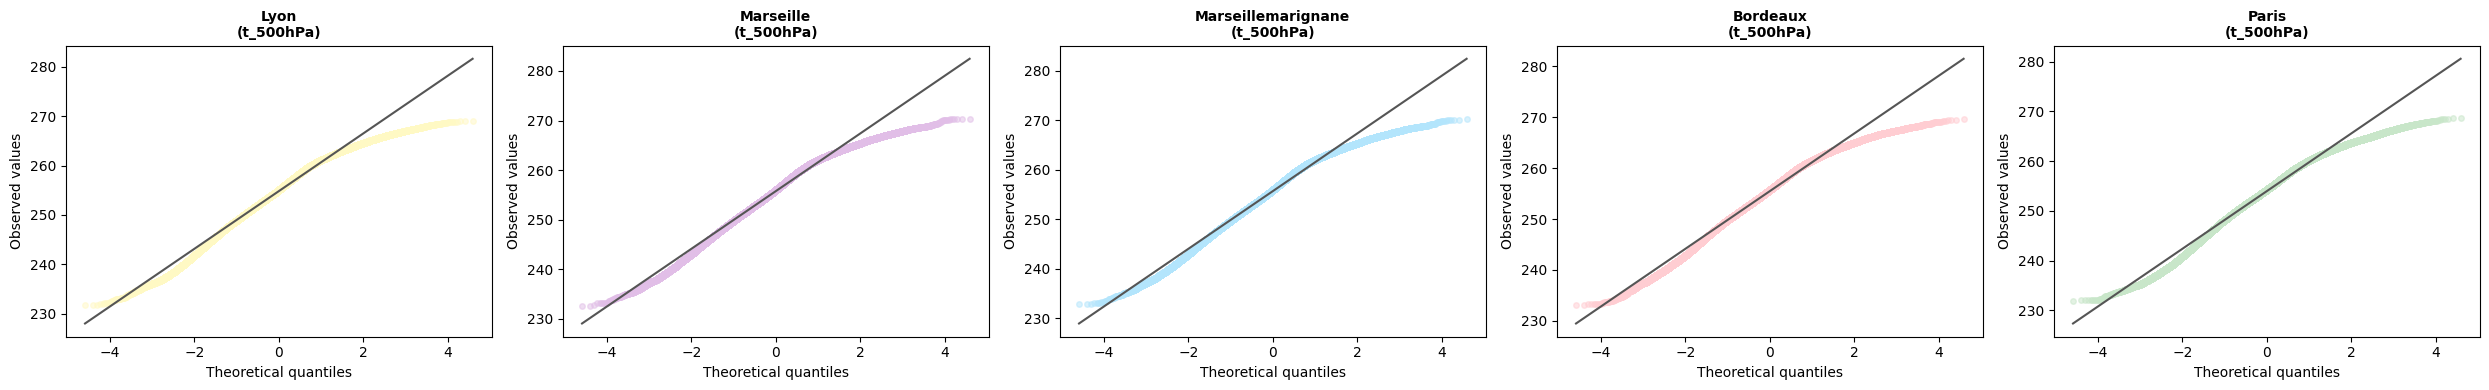

🔍 Start normal distribution check for: t_850hPa


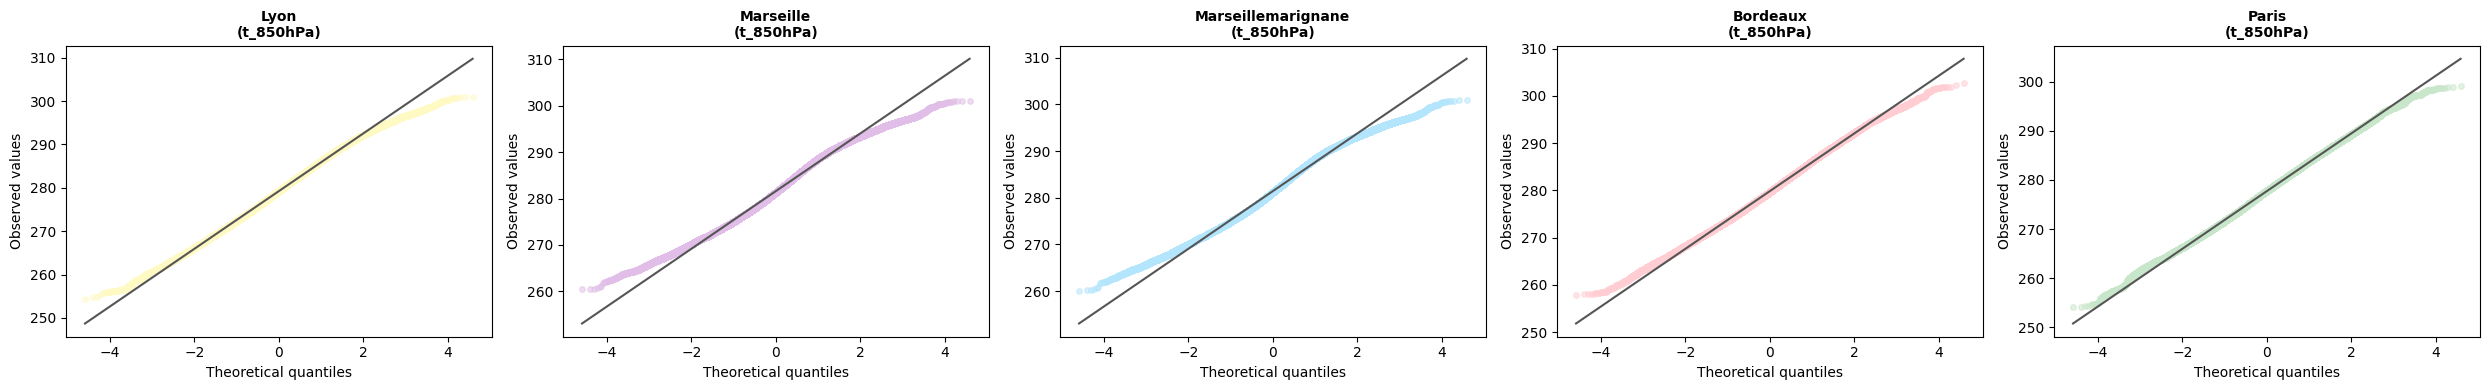

🔍 Start normal distribution check for: temperature_2m


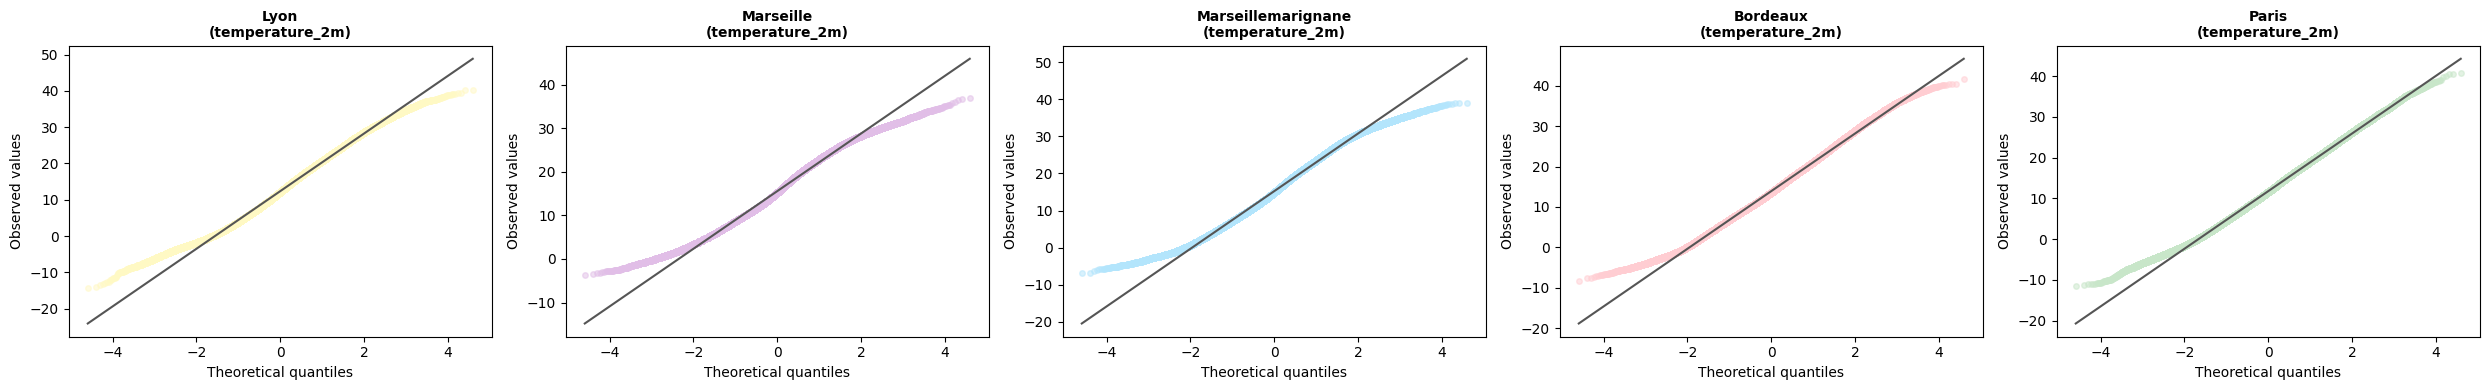

🔍 Start normal distribution check for: u_500hPa


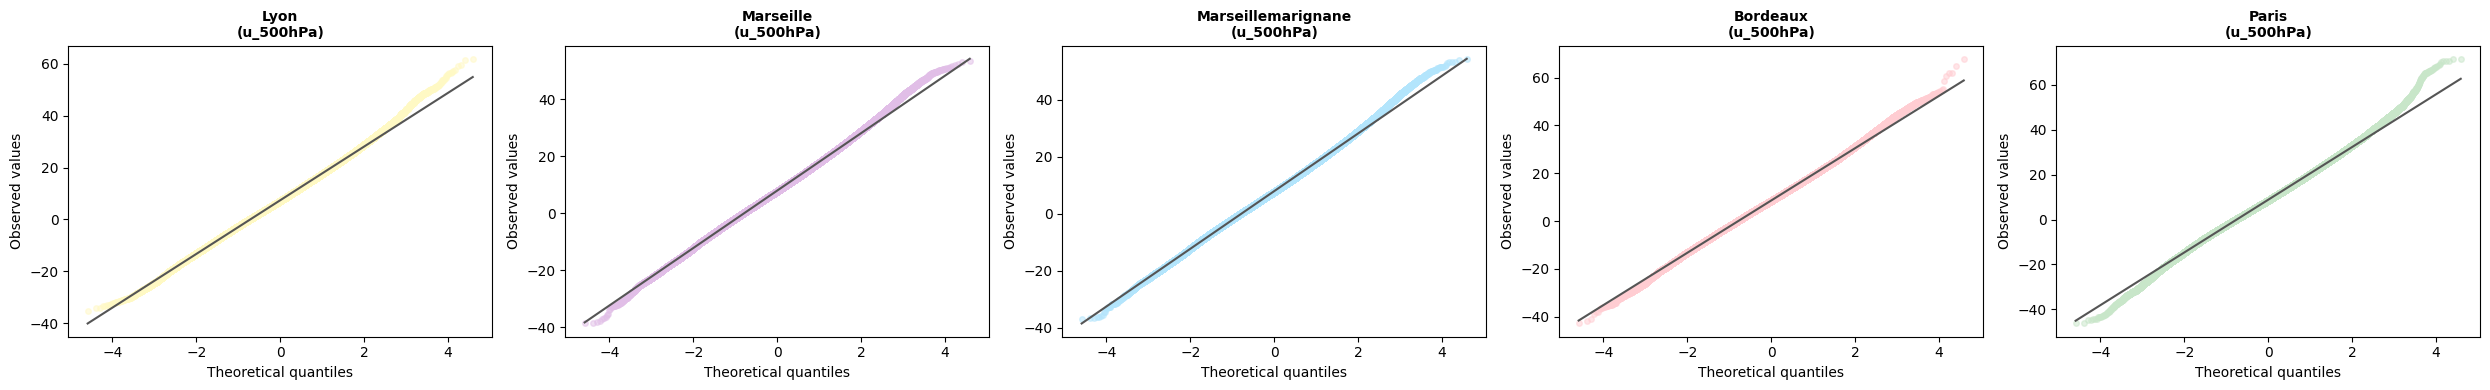

🔍 Start normal distribution check for: u_850hPa


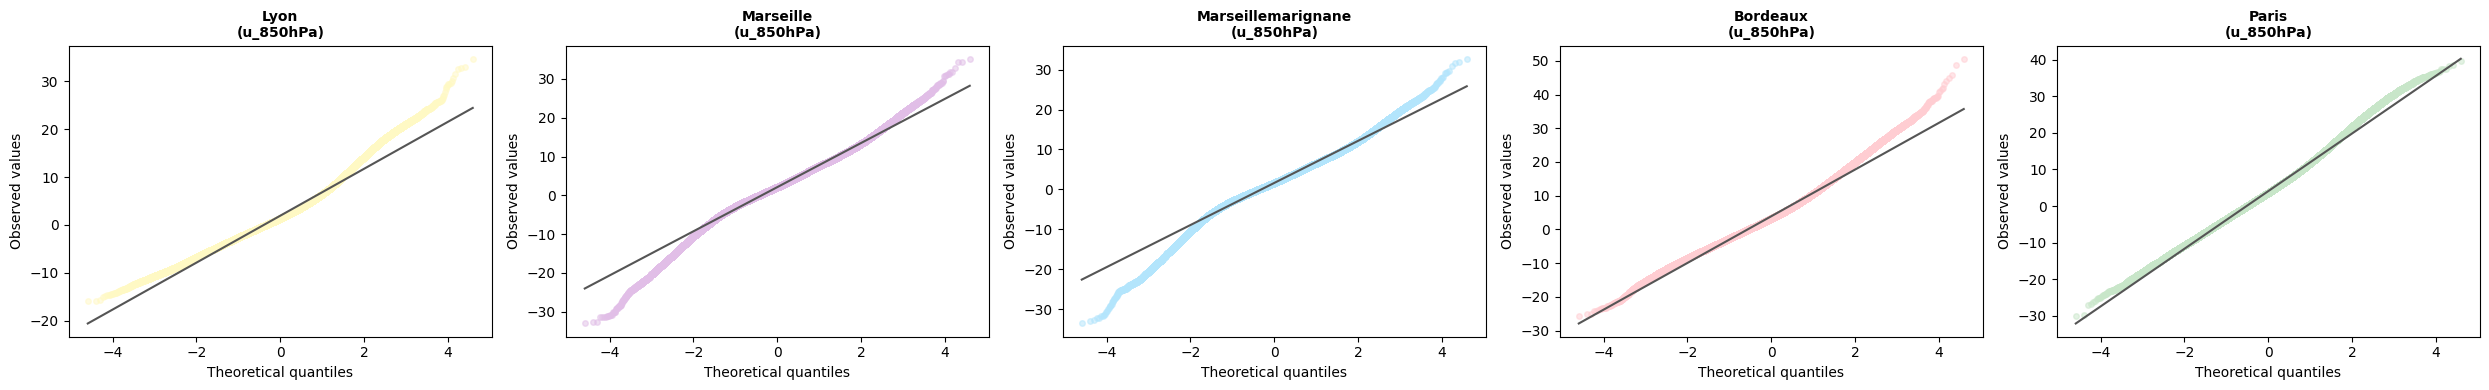

🔍 Start normal distribution check for: v_500hPa


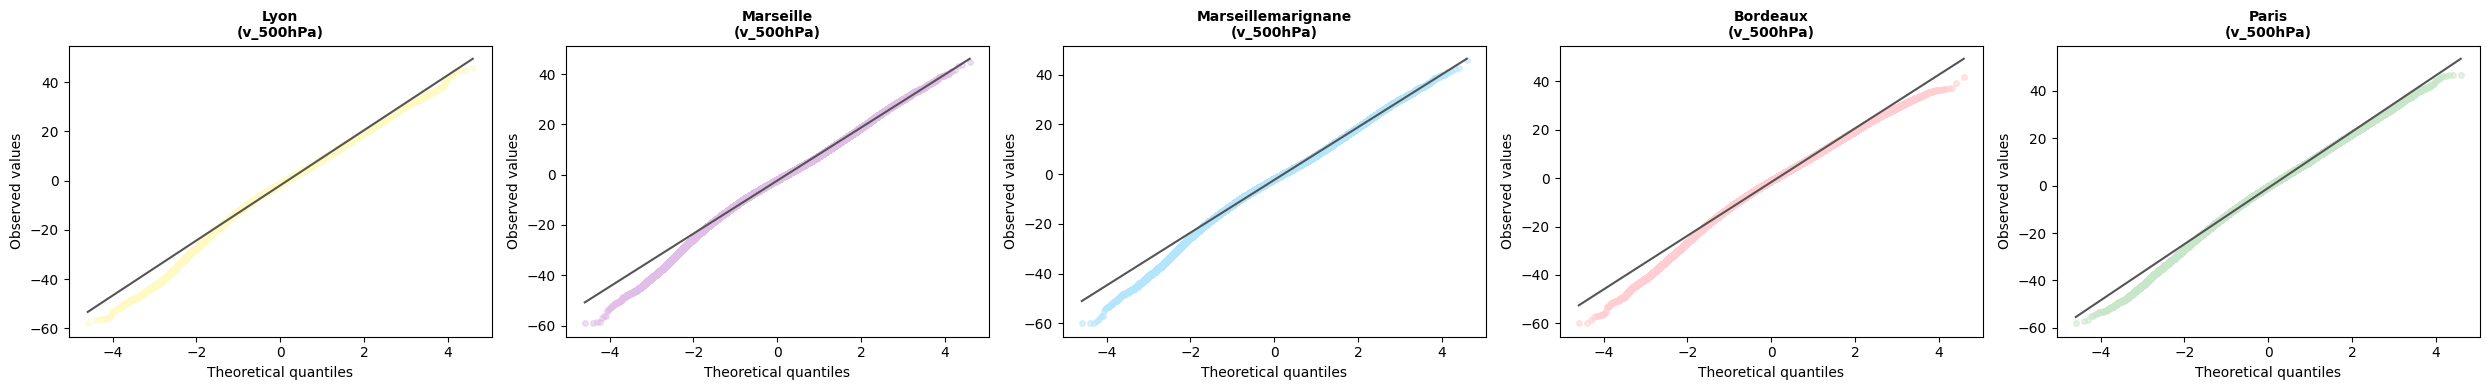

🔍 Start normal distribution check for: v_850hPa


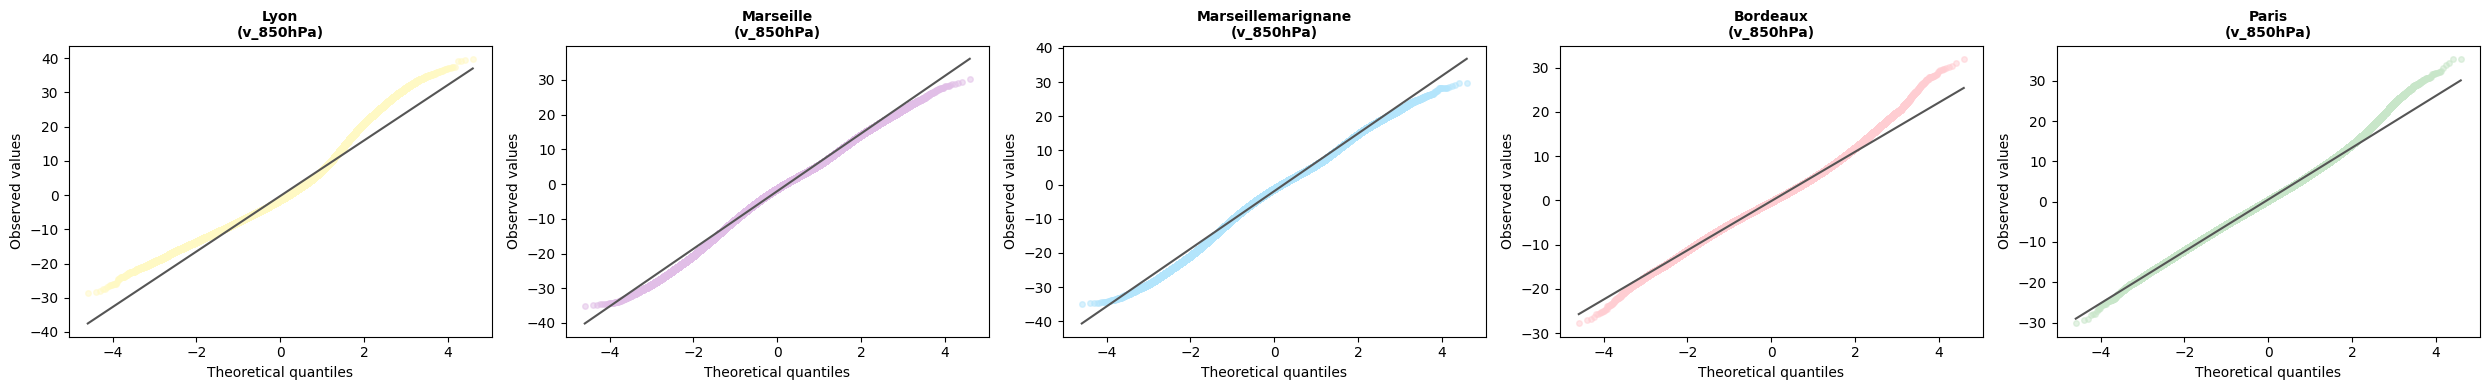

🔍 Start normal distribution check for: wind_dir_cos


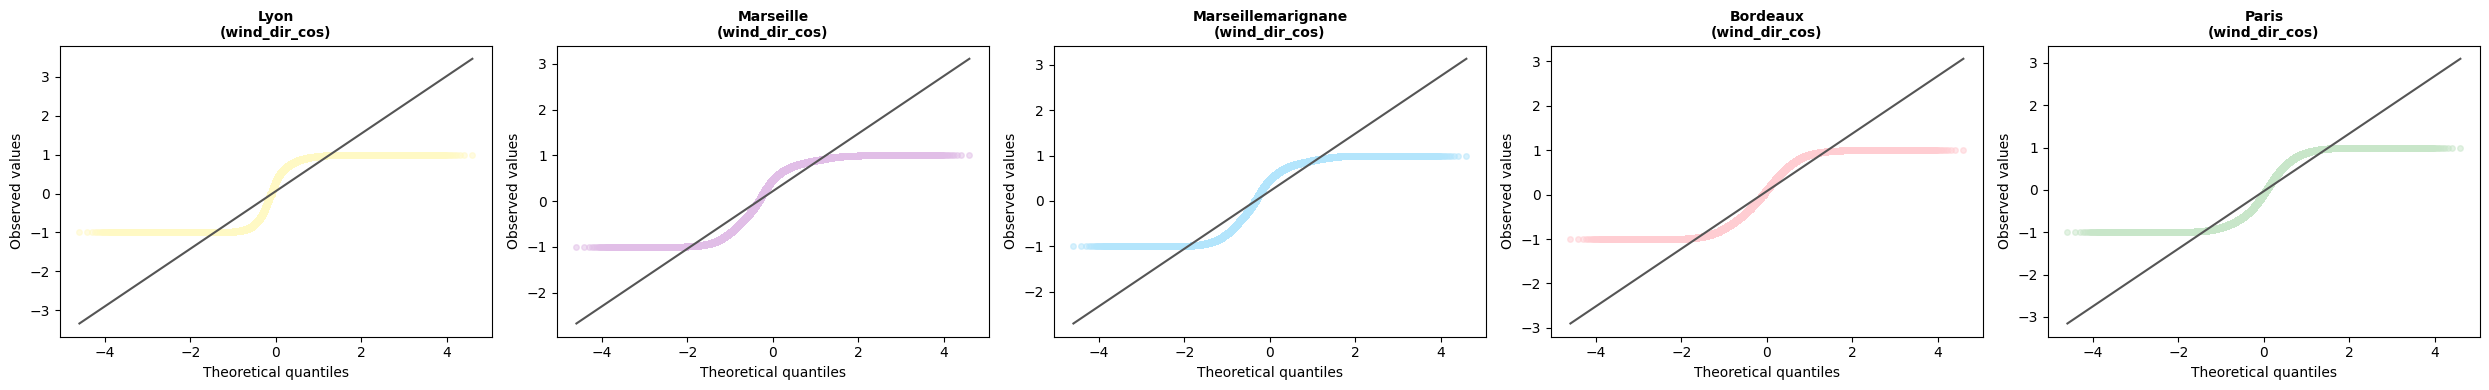

🔍 Start normal distribution check for: wind_dir_sin


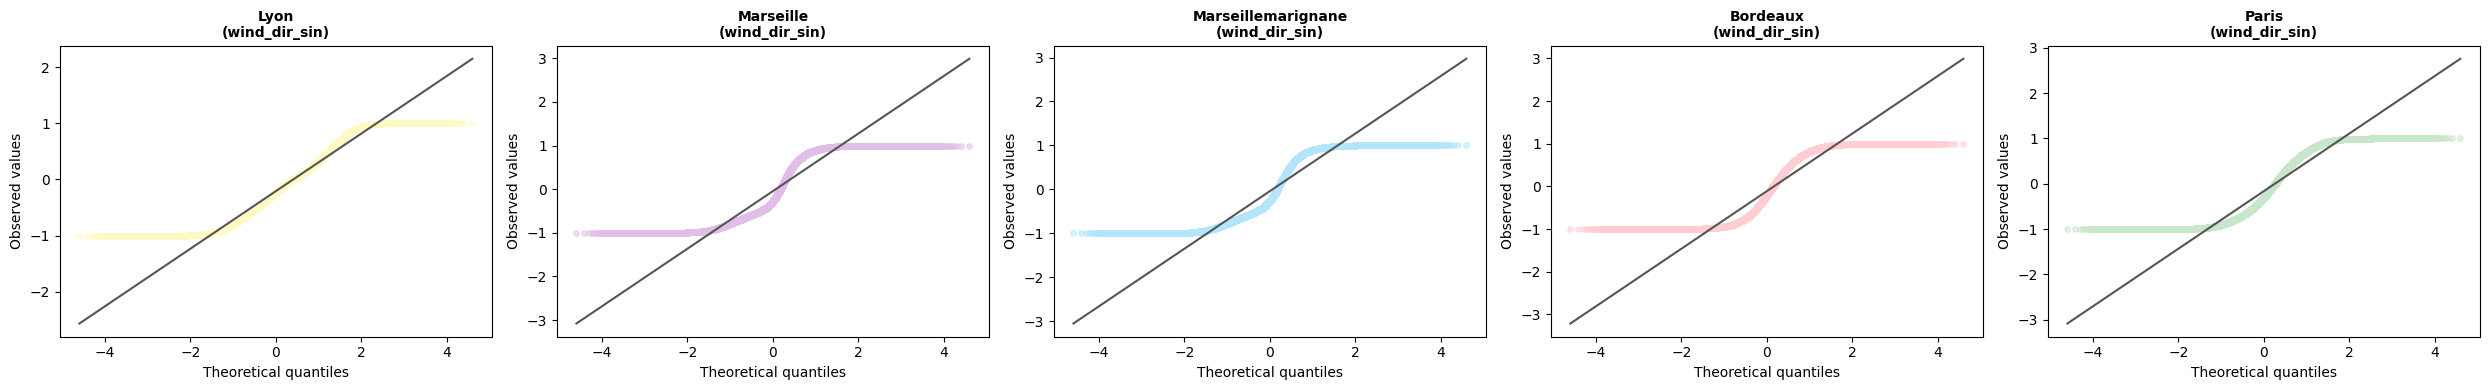

🔍 Start normal distribution check for: wind_speed_10m


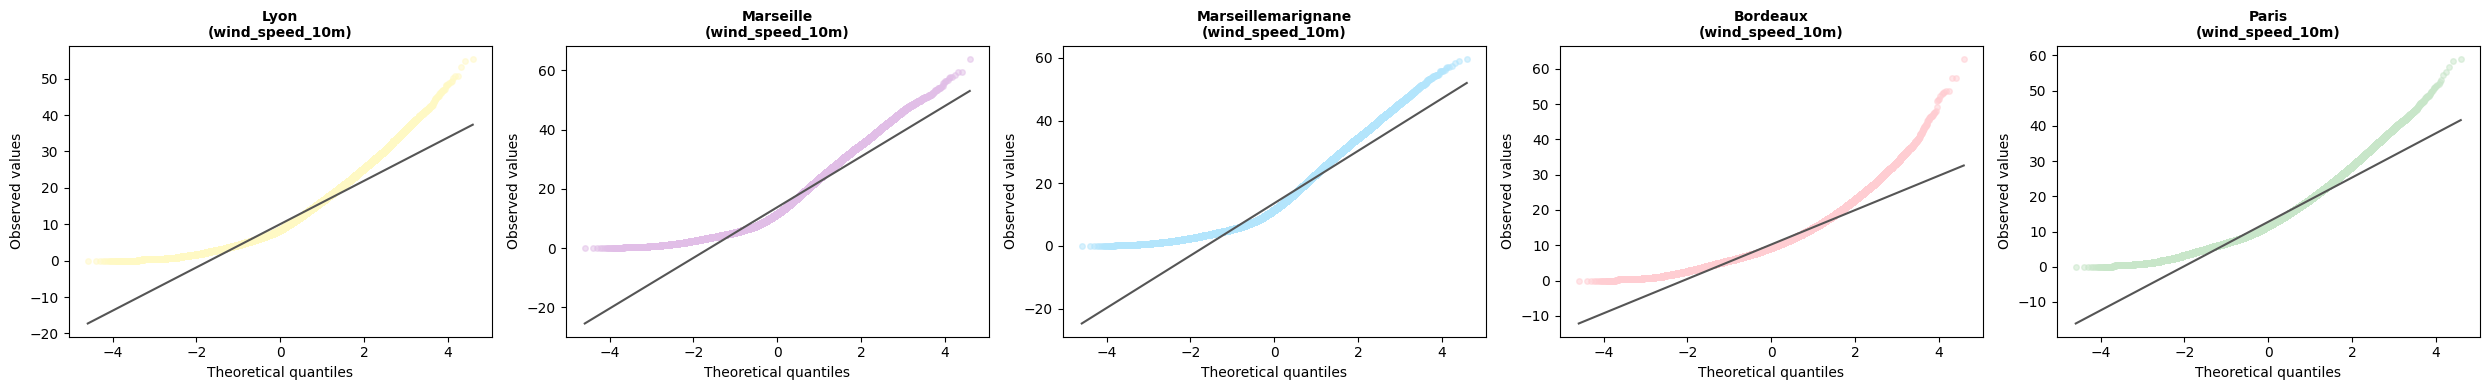

In [4]:
import scipy.stats as stats

# --- COMPLETE Q-Q PLOT ANALYSIS FOR ALL PARAMETERS ---

# We go through every variable we found in the logs.
for var in sorted(list(unique_variables)):
    num_cities = len(all_frames)
    
    # Create one figure per variable (one column per city)
    fig, axes = plt.subplots(1, num_cities, figsize=(5 * num_cities, 4))
    
    # Ensure that axes is always a list (even if there is only one city)
    if num_cities == 1:
        axes = [axes]

    print(f"🔍 Start normal distribution check for: {var}")
    
    for i, (loc, df) in enumerate(all_frames.items()):
        # Prüfen, ob die Stadt diese Variable hat
        if var in df.columns:
            
            city_color = CITY_COLORS.get(loc.lower(), "#F5F5F5")
            
            # Q-Q plot calculation (dropna is important for clean statistics)
            stats.probplot(df[var].dropna(), plot=axes[i])
            
            axes[i].get_lines()[0].set_markerfacecolor(city_color)
            axes[i].get_lines()[0].set_markeredgecolor(city_color)
            axes[i].get_lines()[0].set_alpha(0.5)
            axes[i].get_lines()[0].set_markersize(4)
            
            axes[i].get_lines()[1].set_color('#555555') 
            axes[i].get_lines()[1].set_linewidth(1.5)
            
            axes[i].set_title(f"{loc.title()}\n({var})", fontsize=10, fontweight='bold')
            axes[i].set_xlabel("Theoretical quantiles")
            axes[i].set_ylabel("Observed values")
        else:
            # Falls Variable für diese Stadt fehlt, Feld leer lassen
            axes[i].set_title(f"No data: {loc}")
            axes[i].axis('off')
            
    plt.tight_layout()
    plt.show()

In [5]:
# =========================================================================================
# STATISTICAL PARAMETER EXPLANATION (WEATHER DATA)
# =========================================================================================
# This table explains the meteorological variables analyzed across the five locations.
#
# | Parameter              | Unit    | Description                                         |
# |------------------------|---------|-----------------------------------------------------|
# | temperature_2m         | °C      | Air temperature at 2 meters above ground.           |
# | relative_humidity_2m   | %       | Humidity relative to air saturation.                |
# | pressure_msl           | hPa     | Air pressure normalized to mean sea level.          |
# | shortwave_radiation    | W/m²    | Solar energy reaching the surface.                  |
# | soil_moisture_0_to_7cm | m³/m³   | Water content in the top layer of soil.             |
# | wind_speed_10m         | km/h    | Wind speed measured at 10 meters height.            |
# | wind_direction_10m     | °       | Wind direction (0°=North, 90°=East, 180°=South).    |
# | t_850hPa / t_500hPa    | K       | Temperature at ~1,500m and ~5,500m altitude.        |
# | u_850hPa / u_500hPa    | m/s     | Zonal wind (East-West component). Positive = West.  |
# | v_850hPa / v_500hPa    | m/s     | Meridional wind (North-South component). Positive = South. |
#
# -----------------------------------------------------------------------------------------
# STATISTICAL TERMS:
# -----------------------------------------------------------------------------------------
# # Mean: The arithmetic average (central tendency of the data).
# # Std:  Standard Deviation (measures how much the data fluctuates).
# # Max:  The highest recorded value (useful for identifying extreme events).
#
# -----------------------------------------------------------------------------------------
# KEY OBSERVATIONS FROM THE DATA:
# -----------------------------------------------------------------------------------------
# # Temperature: Marseille is the warmest (~15.5°C), while Paris is the coldest (~11.8°C).
# # Solar: Marseille receives ~38% more solar radiation on average than Paris.
# # Wind: Wind speeds at 500hPa (upper atmosphere) reach up to 71 m/s (approx. 255 km/h),
# #       which is characteristic of the Jetstream.
# =========================================================================================

In [6]:
################################################################################
# CONCLUSION: STATISTICAL INSIGHTS & MODEL JUSTIFICATION (UPDATED)
# 
# 1. NON-NORMALITY & ML CHOICE:
#    The Q-Q plot analysis confirms that parameters like Wind Speed (Max ~64 km/h)
#    and Radiation (Max ~981 W/m²) deviate significantly from normal 
#    distribution. 
#    Conclusion: The presence of "Fat Tails" in these variables necessitates 
#    the use of non-linear models like Random Forest or Gradient Boosting 
#    to accurately capture extreme weather anomalies.
#
# 2. REGIONAL VOLATILITY (Temperature Variance):
#    Lyon shows the highest Temperature Std Dev (7.98), closely followed 
#    by Marseille-Marignane (7.80). Paris and Bordeaux show slightly lower 
#    volatility (~7.1).
#    Conclusion: The model requires higher sensitivity for Lyon to account 
#    for more "volatile" seasonal or daily temperature swings.
#
# 3. PRESSURE DYNAMICS (Variability):
#    Paris indeed shows the highest Pressure Std Dev (9.22 hPa), indicating 
#    more frequent frontal passages and cyclonic activity. Both Marseille 
#    locations are much more stable (~7.01 hPa).
#    Conclusion: Air pressure remains a critical predictor for Northern 
#    regions (Paris), while thermal layers (t_850hPa) and solar radiation 
#    are the primary drivers for the Mediterranean South.
#
# 4. DATA INTEGRITY:
#    The high correlation between Marseille-Marignane and Marseille Center 
#    is confirmed (e.g., identical Pressure Mean of 1015.9 hPa and similar 
#    wind patterns). The recorded wind peaks (up to 63.95 km/h in Marseille) 
#    ensure that the dataset captures high-impact storm events effectively.
################################################################################

In [5]:
import os
import json
import numpy as np
import pandas as pd

# THE FOLDER WHERE THE FILES ARE LOCATED AND ARE TO BE OVERWRITTEN
SOURCE_DIR = "../data/3_outputs"

# List all Parquet files in the folder
parquet_files = [f for f in os.listdir(SOURCE_DIR) if f.endswith('.parquet')]

print(f" SStart in-place transformation for {len(parquet_files)} files in {SOURCE_DIR}...")

for p_file in parquet_files:
    # Define paths
    p_path = os.path.join(SOURCE_DIR, p_file)
    j_path = p_path.replace('.parquet', '.json') # Find the right JSON
    
    try:
        # Loading data
        df = pd.read_parquet(p_path)
        
        # Wind transformation (sin/cos instead of degrees)
        if 'wind_direction_10m' in df.columns:
            rad = df['wind_direction_10m'] * np.pi / 180
            df['wind_dir_sin'] = np.sin(rad)
            df['wind_dir_cos'] = np.cos(rad)
            df.drop(columns=['wind_direction_10m'], inplace=True)
            
            # Overwrite Parquet
            df.to_parquet(p_path, index=False)
            
            # Log-Datei (JSON) anpassen, falls sie existiert
            if os.path.exists(j_path):
                with open(j_path, 'r') as f:
                    meta = json.load(f)
                
                # Update variable list in log (directly from the new DF)
                new_vars = [c for c in df.columns if c != 'timestamp']
                meta['variables']['list'] = new_vars
                meta['variables']['count'] = len(new_vars)
                
                with open(j_path, 'w') as f:
                    json.dump(meta, f, indent=4)
                
                print(f"✅ Updated: {p_file} (including JSON)")
            else:
                print(f" Updated: {p_file} (No JSON found!)")
        else:
            print(f" Skipped: {p_file} (No ‘wind_direction_10m’ column)")

    except Exception as e:
        print(f"❌ Error in {p_file}: {str(e)}")

print("\n All files have been successfully converted and overwritten.")

 SStart in-place transformation for 5 files in ../data/3_outputs...
 Skipped: lyon_1990-2025_vars14_v1.parquet (No ‘wind_direction_10m’ column)
 Skipped: marseille_1990-2025_vars14_v1.parquet (No ‘wind_direction_10m’ column)
 Skipped: marseillemarignane_1990-2025_vars14_v1.parquet (No ‘wind_direction_10m’ column)
 Skipped: bordeaux_1990-2025_vars14_v1.parquet (No ‘wind_direction_10m’ column)
 Skipped: paris_1990-2025_vars14_v1.parquet (No ‘wind_direction_10m’ column)

 All files have been successfully converted and overwritten.


In [6]:
import os
import json
import pandas as pd

SOURCE_DIR = "../data/3_outputs"

# Header for the overview
print(f"{'Stadt':<20} | {'Alt weg?':<10} | {'Sin/Cos?':<10} | {'Log Sync?':<10} | {'Spalten (JSON)'}")
print("-" * 85)

# Find all JSON files (as a basis for the check)
json_files = sorted([f for f in os.listdir(SOURCE_DIR) if f.endswith('.json')])

for j_file in json_files:
    j_path = os.path.join(SOURCE_DIR, j_file)
    p_path = j_path.replace('.json', '.parquet')
    
    if os.path.exists(p_path):
        # Load JSON
        with open(j_path, 'r') as f:
            meta = json.load(f)
        vars_in_log = set(meta['variables']['list'])
        
        # Load parquet
        df = pd.read_parquet(p_path)
        df_cols = set(df.columns)
        
        # Perform checks
        old_gone = 'wind_direction_10m' not in df_cols
        new_there = 'wind_dir_sin' in df_cols and 'wind_dir_cos' in df_cols
        
        # Sync check: Does the list in the log match the columns in the Parquet file (minus timestamp)?
        parquet_vars = df_cols - {'timestamp'}
        sync_ok = vars_in_log == parquet_vars
        
        # Status-Icons
        status_old = "✅" if old_gone else "❌"
        status_new = "✅" if new_there else "❌"
        status_sync = "✅" if sync_ok else "⚠️"
        
        # City name from Meta or file name
        city = meta.get('city', j_file.split('_')[0])
        
        print(f"{city:<20} | {status_old:<10} | {status_new:<10} | {status_sync:<10} | {len(vars_in_log)} Vars")

print("\n Detailed check of the first lines (random sample):")
# Display the header of the last processed file for visual inspection
display(df.head(3))

Stadt                | Alt weg?   | Sin/Cos?   | Log Sync?  | Spalten (JSON)
-------------------------------------------------------------------------------------
bordeaux             | ✅          | ✅          | ✅          | 14 Vars
lyon                 | ✅          | ✅          | ✅          | 14 Vars
marseille            | ✅          | ✅          | ✅          | 14 Vars
marseillemarignane   | ✅          | ✅          | ✅          | 14 Vars
paris                | ✅          | ✅          | ✅          | 14 Vars

 Detailed check of the first lines (random sample):


,timestamp,temperature_2m,relative_humidity_2m,pressure_msl,shortwave_radiation,soil_moisture_0_to_7cm,wind_speed_10m,t_850hPa,t_500hPa,u_850hPa,u_500hPa,v_850hPa,v_500hPa,wind_dir_sin,wind_dir_cos
0,1990-01-01 00:00:00,0.73,95.065414,1019.200012,0.0,0.347,5.904439,276.23230,250.45444,2.197479,4.152817,2.372330,5.153687,0.609712,-0.792623
1,1990-01-01 01:00:00,0.73,95.065414,1018.900024,0.0,0.347,6.369050,276.51636,250.35200,2.194046,4.487045,1.864441,5.364166,0.678280,-0.734804
2,1990-01-01 02:00:00,0.63,95.061455,1018.700012,0.0,0.347,6.618519,276.69373,250.24121,1.912979,4.817444,1.285126,5.608978,0.707105,-0.707108
